In [154]:
# Imports
#!/usr/bin/env python
# -*- coding: utf-8 -*-
import numpy as np
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
from sklearn.utils.extmath import randomized_svd
from prettytable import PrettyTable

import os
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.animation import FuncAnimation
from dotenv import dotenv_values 
from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage
import scipy.io
import pyvista as pv
import h5py
from scipy import signal
import dask.array as da
import cvxpy as cp
import psycopg2
import hdf5storage
import h5py
import pickle
import logging
from sys import getsizeof



config = dotenv_values("../.env")

# Read in Data

In [155]:
# Helper functions for working with database
def get_db_connection():
    conn = psycopg2.connect(
        dbname='simDB',
        user='user',
        password='password',
        host='localhost',
        port='5432'
    )
    return conn

def fetch_trial_data(conn, trial_id,n=1,limit=500):
    try:
        cur = conn.cursor()
        
        # Fetch data for the given trial_id
        query = '''
        SELECT timestep, simulation_time, input_data, output_data, y_ref, x_hat
        FROM simulation_data
        WHERE trial_id = %s AND MOD(timestep, %s) = 0
        ORDER BY timestep ASC LIMIT %s;
        '''
        cur.execute(query, (trial_id, n, limit))
        rows = cur.fetchall()
        
        # Deserialize data
        data = []
        for row in rows:
            timestep, simulation_time, input_data_bin, output_data_bin, y_ref_bin, x_hat_bin = row
            input_data = np.array(pickle.loads(input_data_bin)).flatten()
            output_data = np.array(pickle.loads(output_data_bin)).flatten()
            y_ref = np.array(pickle.loads(y_ref_bin)).flatten()
            x_hat = np.array(pickle.loads(x_hat_bin)).flatten()
            data.append((timestep, simulation_time, input_data, output_data, y_ref, x_hat))
        
        cur.close()
        return data
    except Exception as e:
        print(f"Error fetching data for trial_id {trial_id}: {e}")
        return None

In [156]:
# Trial Parameters
trial_id = 196
timesteps = 2000
n = 1

In [157]:
# Read a single timestep of data from the database to get dimensions of stuff correct
conn = get_db_connection()
data = fetch_trial_data(conn, trial_id, n, 1)
conn.close()
timestep, simulation_time, input_data, output_data, y_ref, x_hat = data[0]
outputDim = np.size(output_data)
inputDim = np.size(input_data)
x_hatDim = np.size(x_hat)

print(f"OutputDim: {outputDim}, InputDim: {inputDim}, x_hatDim: {x_hatDim}")



OutputDim: 40, InputDim: 6, x_hatDim: 18


In [158]:
# Read all timesteps of data from data
conn = get_db_connection()
data = fetch_trial_data(conn, trial_id, n, timesteps)
conn.close()

simulation_timesteps = np.array([row[0] for row in data])
simulation_times = np.array([row[1] for row in data])
input_data = np.array([row[2] for row in data]).T
output_data = np.array([row[3] for row in data]).T
y_refs = np.array([row[4] for row in data]).T
x_hats = np.array([row[5] for row in data]).T

In [159]:
output_data.shape
# TODO: Look into why y_ref has dimension 40040 instead of 40


(40, 500)

In [160]:
# Load in data from npy file
Y_fom = output_data
U_fom = input_data
Y0_fom = Y_fom[:,0]
# Center Y_fom about neutral position
Y_fom = Y_fom-Y0_fom[:,np.newaxis]

In [161]:
Y_fom.shape

(40, 500)

# RHC Analysis

## Control Inputs

The goal here is to analyze the control inputs a given trial

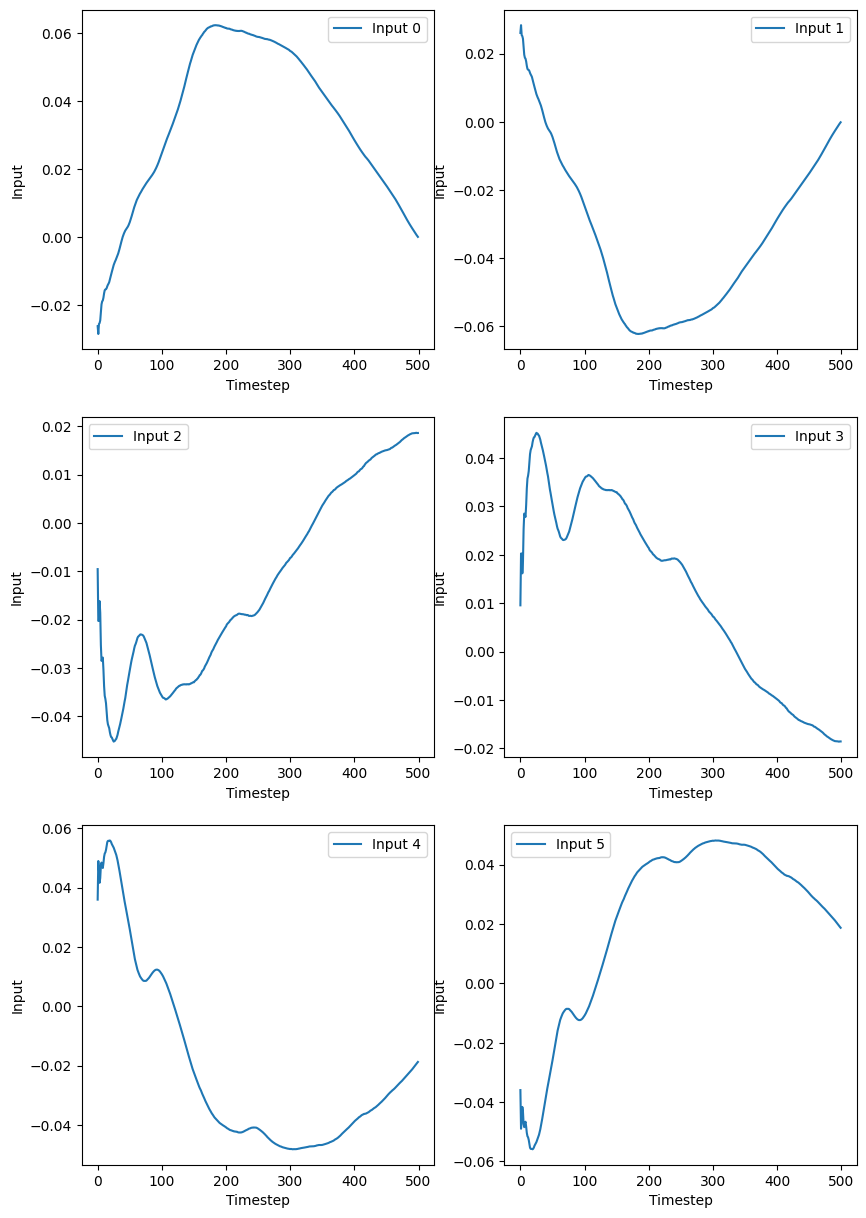

In [162]:
# Plot all 6 inputs separately on subplots
fig, axs = plt.subplots(3, 2, figsize=(10, 15))
for i in range(6):
    axs[i//2, i%2].plot(U_fom[i,:], label="Input " + str(i))
    axs[i//2, i%2].set_xlabel("Timestep")
    axs[i//2, i%2].set_ylabel("Input")
    axs[i//2, i%2].legend()

## Trajectory Tracking

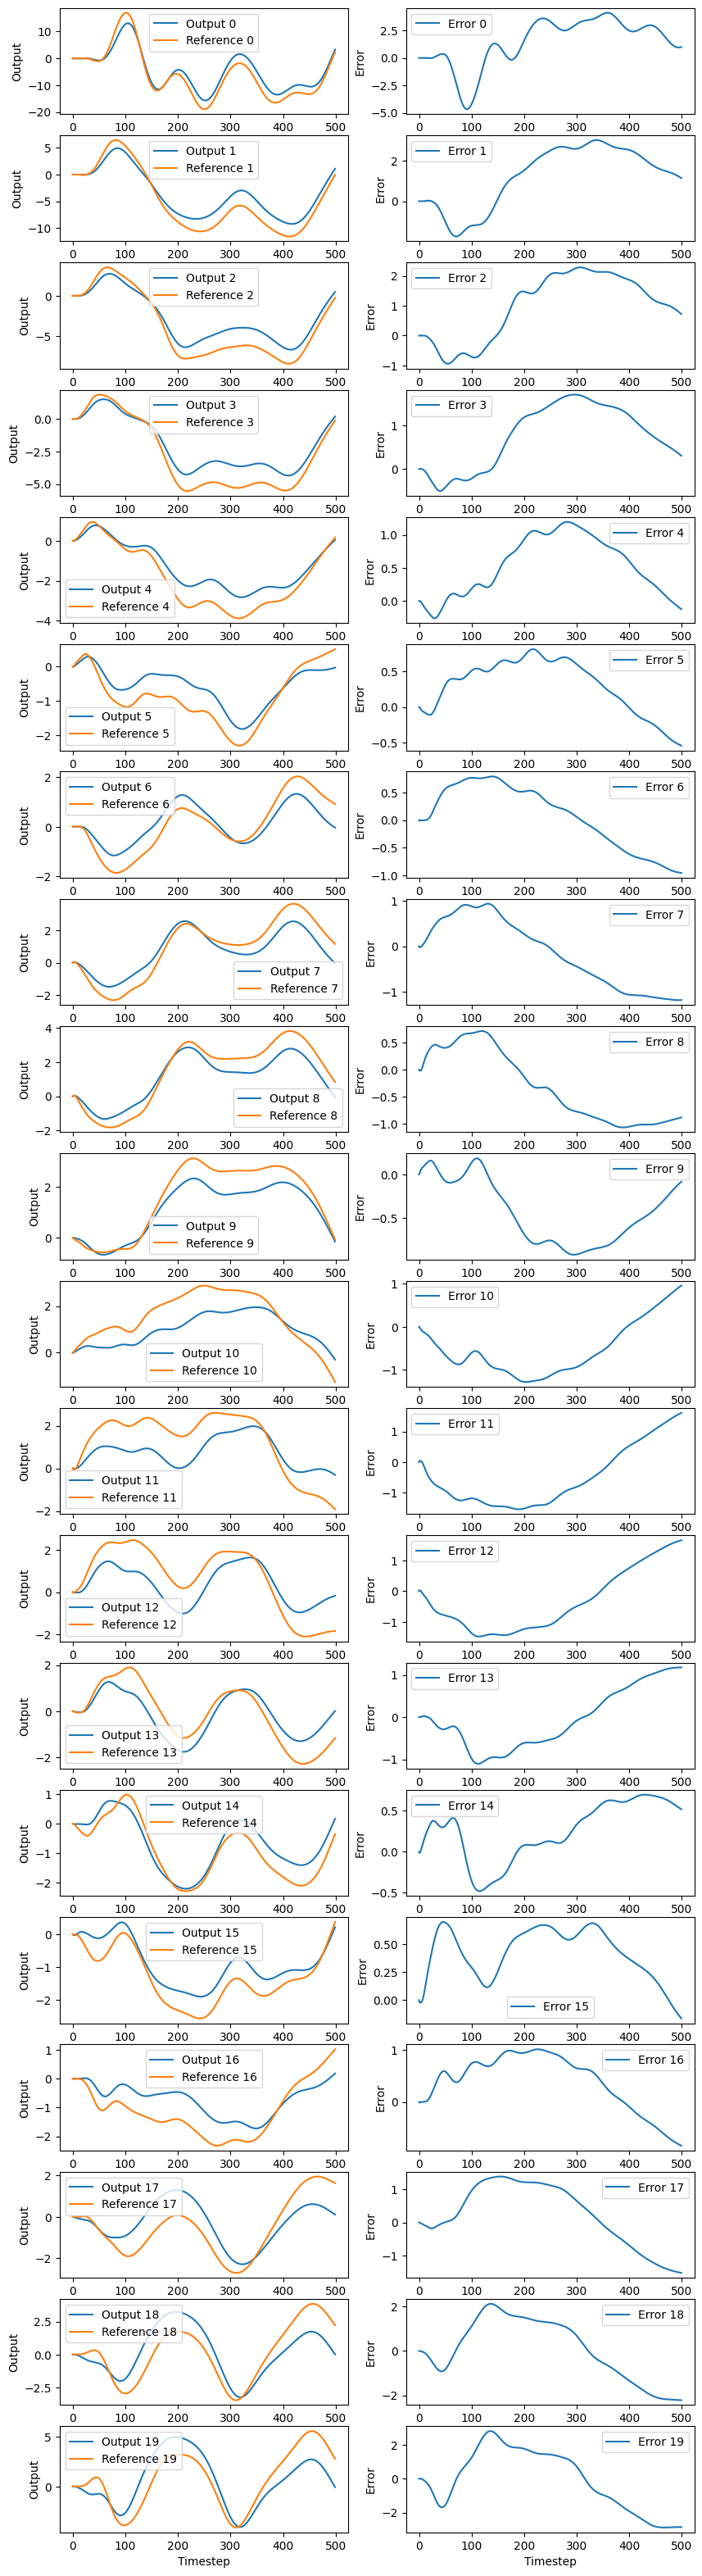

In [163]:
# Show output trajectories against reference trajectories for all 40 outputs
fig, axs = plt.subplots(20,2, figsize=(10, 40))
plotTimetsteps = timesteps
for i in range(20):
    axs[i, 0].plot(Y_fom[2*i+1,:plotTimetsteps], label="Output " + str(i))
    axs[i, 0].plot(y_refs[2*i+1,:plotTimetsteps], label="Reference " + str(i))
    axs[i, 0].set_xlabel("Timestep")
    axs[i, 0].set_ylabel("Output")
    axs[i, 0].legend()

    
    axs[i, 1].plot(Y_fom[2*i+1,:plotTimetsteps]-y_refs[2*i+1,:plotTimetsteps], label="Error " + str(i))
    axs[i, 1].set_xlabel("Timestep")
    axs[i, 1].set_ylabel("Error")
    axs[i, 1].legend()




RMS Errors:  [2.60668647 1.93308225 1.46914098 1.05058401 0.68989008 0.48028778
 0.56958834 0.76116801 0.7173125  0.56609835 0.80281851 1.08861919
 1.04081177 0.70621412 0.43320244 0.4741795  0.66412816 0.95472699
 1.37273368 1.78276835]


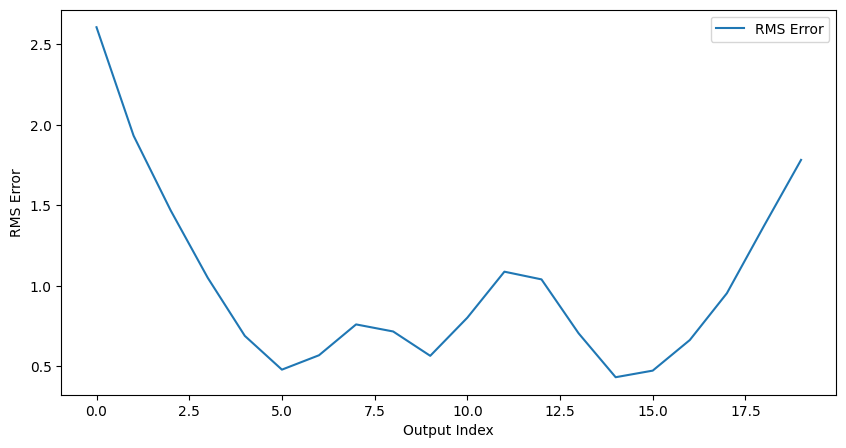

Average RMS Error:  1.0082020744360094
Maximum RMS Error:  2.606686467405966
Minimum RMS Error:  0.4332024435001435


In [164]:
# Calculate RMS error over odd indexed outputs
rms_errors = np.zeros((20))
for i in range(20):
    rms_errors[i] = np.sqrt(np.mean((Y_fom[2*i+1,:]-y_refs[2*i+1,:])**2))
print("RMS Errors: ", rms_errors)
# Plot RMS errors
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(rms_errors, label="RMS Error")
ax.set_xlabel("Output Index")
ax.set_ylabel("RMS Error")
ax.legend()
plt.show()
# Print average RMS error
print("Average RMS Error: ", np.mean(rms_errors))
# Print maximum RMS error
print("Maximum RMS Error: ", np.max(rms_errors))
# Print minimum RMS error
print("Minimum RMS Error: ", np.min(rms_errors))

Text(0.5, 1.0, 'TailOutputTracking_Trial196')

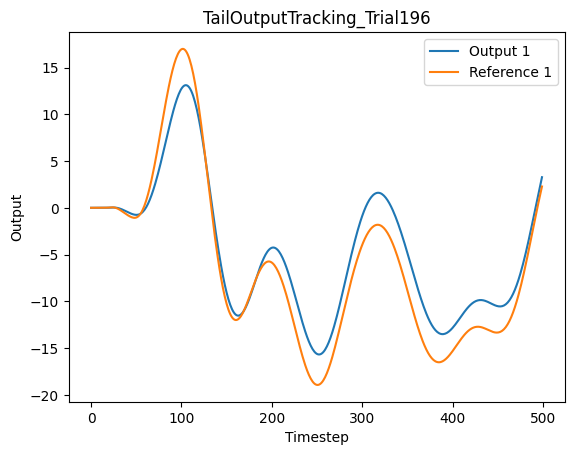

In [165]:
# Generate svg of just output index 1 against its reference trajectory with trial id in title
fig, ax = plt.subplots()
ax.plot(Y_fom[1,:], label="Output 1")
ax.plot(y_refs[1,:], label="Reference 1")
ax.set_xlabel("Timestep")
ax.set_ylabel("Output")
ax.legend()
ax.set_title(f"TailOutputTracking_Trial{trial_id}")
# plt.savefig(f"TailOutputTracking_Trial{trial_id}.svg")

### Tracking video

In [166]:
# # Generate video of output centerline trajectories against reference centerline trajectories 
# animationFilepath = filepath + "outputCenterlineTrajectories.mp4"
# numFrames = timesteps-5
# fps = 60
# duration = numFrames/fps
# # Set up figure for animation
# fig, ax = plt.subplots()
# # Animation callback
# def animate(t):
#     global y_groundTruth_online, y_ref_online, Y0_fom
#     i = int(round(t*fps))
#     ax.clear()
#     # Reshape outputs
#     output_i = y_groundTruth_online[:,i].reshape((20,2))
#     output_i[:,0] = output_i[:,0] +  Y0_fom.reshape((20,2))[:,0] # Only offset the x coordinate
#     ref_i = y_ref_online[:,i].reshape((20,2))
#     ref_i[:,0] = ref_i[:,0] +  Y0_fom.reshape((20,2))[:,0] # Only offset the x coordinate
#     ax.plot(-ref_i[:,0], ref_i[:,1], label="Reference", linewidth = 5, color = 'red', linestyle='dashed', ) # flip x sign to make things look nicer
#     ax.plot(-output_i[:,0], output_i[:,1], label="Output", linewidth = 5, color = 'k') # flip x sign to make things look nicer
#     ax.set_xlabel("x [mm]")
#     ax.set_ylabel("z [mm]")
#     # Set axis limits
#     ax.set_ylim([-25, 25])
#     # ax.set_xlim([-5, 2000])
#     ax.set_title("Timestep: " + str(i))
#     ax.legend()
#     return mplfig_to_npimage(fig)

# animation = VideoClip(animate, duration=duration)
# animation.write_videofile(animationFilepath, fps=fps)

### Tracking Error